#  第三章 &nbsp; &nbsp; word2vec
接着上一章，本章的主题仍是单词的分布式表示。在上一章中，我们使用基于计数的方法得到了单词的分布式表示。本章我们将讨论该方法的替代方法，即基于推理的方法。

顾名思义，基于推理的方法使用了推理机制。当然，这里的推理机制用的是神经网络。本章，著名的 word2vec 将会登场。我们将花很多时间考察 word2vec 的结构，并通过代码实现来加深对它的理解。

本章的目标是实现一个简单的 word2vec。这个简单的 word2vec 会优先考虑易理解性，从而牺牲一定的处理效率。因此，我们不会用它来处理大规模数据集，但用它处理小数据集毫无问题。下一章我们会对这个简单的 word2vec 进行改进，从而完成一个“真正的” word2vec。现在，让我们一起进入基于推理的方法和 word2vec 的世界吧！

## 基于推理的方法和神经网络
用向量表示单词的研究最近正在如火如荼地展开，其中比较成功的方法大致可以分为两种：一种是基于计数的方法；另一种是基于推理的方法。虽然两者在获得单词含义的方法上差别很大，但是两者的背景都是分布式假设。

本节我们将指出基于计数的方法的问题，并从宏观角度说明它的替代方法——基于推理的方法的优点。另外，为了做好 word2vec 的准备工作，我们会看一个用神经网络处理单词的例子。

## 基于计数的方法的问题
如上一章所说，基于计数的方法根据一个单词周围的单词的出现频数来表示该单词。具体来说，先生成所有单词的共现矩阵，再对这个矩阵进行 SVD，以获得密集向量（单词的分布式表示）。但是，基于计数的方法在处理大规模语料库时会出现问题。

在现实世界中，语料库处理的单词数量非常大。比如，据说英文的词汇量超过 100 万个。如果词汇量超过 100 万个，那么使用基于计数的方法就需要生成一个 100 万 × 100 万的庞大矩阵，但对如此庞大的矩阵执行 SVD 显然是不现实的。

对于一个$n \times n$的矩阵，SVD的复杂度是$O(n^3)$，这表示计算量与$n$的立方成比例增长。如此大的计算成本，即便是超级计算机也无法胜任。实际上，利用近似方法和稀疏矩阵的性质，可以在一定程度上提高处理速度，但还是需要大量的计算资源和时间。

基于计数的方法使用整个语料库的统计数据（共现矩阵和 PPMI 等），通过一次处理（SVD 等）获得单词的分布式表示。而基于推理的方法使用神经网络，通常在 mini-batch 数据上进行学习。这意味着神经网络一次只需要看一部分学习数据（mini-batch），并反复更新权重。这种学习机制上的差异如图所示。

<img src="./fig/svd_vs_network.png" alt="svd_vs_network" style="display: block; margin: 0 auto;">

如图所示，基于计数的方法一次性处理全部学习数据；反之，基于推理的方法使用部分学习数据逐步学习。这意味着，在词汇量很大的语料库中，即使 SVD 等的计算量太大导致计算机难以处理，神经网络也可以在部分数据上学习。并且，神经网络的学习可以使用多台机器、多个 GPU 并行执行，从而加速整个学习过程。在这方面，基于推理的方法更有优势。

基于推理的方法和基于计数的方法相比，还有一些其他的优点。关于这一点，在详细说明基于推理的方法（特别是 word2vec）之后，我们会在之后的章节再次讨论。

## 基于推理的方法的概要
基于推理的方法的主要操作是“推理”。如下图所示，当给出周围的单词（上下文）时，预测“?”处会出现什么单词，这就是推理。

<img src="./fig/context_predict.png" alt="context_predict" style="display: block; margin: 0 auto;">

解开图中的推理问题并学习规律，就是基于推理的方法的主要任务。通过反复求解这些推理问题，可以学习到单词的出现模式。从“模型视角”出发，这个推理问题如下图所示。

<img src="./fig/predict_way.png" alt="predict_way" style="display: block; margin: 0 auto;">

如图所示，基于推理的方法引入了某种模型，我们将神经网络用于此模型。这个模型接收上下文信息作为输入，并输出（可能出现的）各个单词的出现概率。在这样的框架中，使用语料库来学习模型，使之能做出正确的预测。另外，作为模型学习的产物，我们得到了单词的分布式表示。这就是基于推理的方法的全貌。

基于推理的方法和基于计数的方法一样，也基于分布式假设。分布式假设假设“单词含义由其周围的单词构成”。基于推理的方法将这一假设归结为了上面的预测问题。由此可见，不管是哪种方法，如何对基于分布式假设的“单词共现”建模都是最重要的研究主题。

## 神经网络中单词的处理方法
从现在开始，我们将使用神经网络来处理单词。但是，神经网络无法直接处理 you 或 say 这样的单词，要用神经网络处理单词，需要先将单词转化为固定长度的向量。对此，一种方式是将单词转换为 one-hot 表示（ one-hot 向量）。在 one-hot 表示中，只有一个元素是1，其他元素都是0。

我们来看一个 one-hot 表示的例子。和上一章一样，我们用“You say goodbye and I say hello.”这个一句话的语料库来说明。在这个语料库中，一共有7个单词（“you”“say”“goodbye”“and”“i”“hello”“.”）。此时，各个单词可以转化为下图所示的 one-hot 表示。

<img src="./fig/word_one_hot.png" alt="word_one_hot" style="display: block; margin: 0 auto;">

如图所示，单词可以表示为文本、单词 ID 和 one-hot 表示。此时，要将单词转化为 one-hot 表示，就需要准备元素个数与词汇个数相等的向量，并将单词 ID 对应的元素设为 1，其他元素设为 0。像这样，只要将单词转化为固定长度的向量，神经网络的输入层的神经元个数就可以固定下来。

<img src="./fig/network_one_hot.png" alt="network_one_hot" style="display: block; margin: 0 auto;">

如图所示，输入层由 7 个神经元表示，分别对应于 7 个单词（第 1 个神经元对应于 you，第 2 个神经元对应于 say ）。

现在事情变得很简单了。因为只要将单词表示为向量，这些向量就可以由构成神经网络的各种“层”来处理。比如，对于one-hot表示的某个单词，使用全连接层对其进行变换的情况如下图所示。

<img src="./fig/words_network.png" alt="words_network" style="display: block; margin: 0 auto;">

如图所示，全连接层通过箭头连接所有节点。这些箭头拥有权重（参数），它们和输入层神经元的加权和成为中间层的神经元。另外，本章使用的全连接层将省略偏置（这是为了配合后文对 word2vec 的说明）。

没有偏置的全连接层相当于在计算矩阵乘积。在很多深度学习的框架中，在生成全连接层时，都可以选择不使用偏置。在本书中，不使用偏置的全连接层相当于 MatMul 层（该层已经在第 1 章中实现）。

在上图中，神经元之间的连接是用箭头表示的。之后，为了明确地显示权重，我们将使用下图所示的方法。

<img src="./fig/simple_words_network.png" alt="simple_words_network" style="display: block; margin: 0 auto;">

现在，我们看一下代码。这里的全连接层变换可以写成如下的 Python代码。

In [1]:
import numpy as np

c = np.array([[1, 0, 0, 0, 0, 0, 0]]) # one-hot 向量
W = np.random.randn(7, 3) # 权重矩阵
h = np.dot(c, W) # 矩阵乘法，中间节点
print(h) # 输出中间节点

[[-0.47772173 -0.25598657 -1.46795473]]


这段代码将单词 ID 为 0 的单词表示为了 one - hot 表示，并用全连接层对其进行了变换。作为复习，全连接层的计算通过矩阵乘积进行。这可以用 NumPy 的 `np.dot()` 来实现（省略偏置）。

这里，输入数据(变量c)的维数(ndim)是2。这是考虑了mini-batch处理，将各个数据保存在了第1维(0维度)中。

希望读者注意一下 $c$ 和 $W$ 进行矩阵乘积计算的地方。此处，$c$ 是 one - hot 表示，单词 ID 对应的元素是 1，其他地方都是 0。因此，如图所示，上述代码中的 $c$ 和 $W$ 的矩阵乘积相当于“提取”权重的对应行向量。

<img src="./fig/matrix_one_hot.png" alt="matrix_one_hot" style="display: block; margin: 0 auto;">

这里，仅为了提取权重的行向量而进行矩阵乘积计算好像不是很有效率。关于这一点，我们将在之后的章节进行改进。另外，上述代码的功能也可以使用第 1 章中实现的 MatMul 层完成，如下所示。


In [2]:
import sys
sys.path.append('..') # 为了导入父目录的文件而进行的设定
import numpy as np
from common.layers import MatMul

c = np.array([[1, 0, 0, 0, 0, 0, 0]]) # one-hot 向量
W = np.random.randn(7, 3) # 权重矩阵
layer = MatMul(W) # MatMul层
h = layer.forward(c) # 前向传播
print(h) # 输出中间节点

[[-1.28901725 -0.78022662  0.33600646]]


## 简单的 word2vec 
上一节我们学习了基于推理的方法，并基于代码讨论了神经网络中单词的处理方法，至此准备工作就完成了，现在是时候实现 word2vec 了。

我们要做的事情是将神经网络嵌入到模型中。这里，我们使用由原版 word2vec 提出的名为 **continuous bag-of-words（CBOW）** 的模型作为神经网络。

word2vec一词最初用来指程序或者工具，但是随着该词的流行，在某些语境下，也指神经网络的模型。正确地说，CBOW模型和skip-gram模型是word2vec中使用的两个神经网络。本节我们将主要讨论CBOW模型。关于这两个模型的差异，我们将在之后的章节详细介绍。

## CBOW模型的推理
CBOW 模型是根据上下文预测目标词的神经网络（“目标词”是指中间的单词，它周围的单词是“上下文”）。通过训练这个 CBOW 模型，使其能尽可能地进行正确的预测，我们可以获得单词的分布式表示。

CBOW 模型的输入是上下文。这个上下文用 `['you', 'goodbye']` 这样的单词列表表示。我们将其转换为 one-hot 表示，以便 CBOW 模型可以进行处理。在此基础上，CBOW 模型的网络可以画成下图这样。

<img src="./fig/CBOW_network.png" alt="CBOW_network" style="display: block; margin: 0 auto;">

上图是 CBOW 模型的网络。它有两个输入层，经过中间层到达输出层。这里，从输入层到中间层的变换由相同的全连接层（权重为 $\boldsymbol{W}_{\text{in}}$）完成，从中间层到输出层神经元的变换由另一个全连接层（权重为 $\boldsymbol{W}_{\text{out}}$）完成。

这里，因为我们对上下文仅考虑两个单词，所以输入层有两个。如果对上下文考虑$N$个单词，则输入层会有$N$个。

现在，我们注意一下上图的中间层。此时，中间层的神经元是各个输入层经全连接层变换后得到的值的“平均”。就上面的例子而言，经全连接层变换后，第 1 个输入层转化为 $\boldsymbol{h}_1$，第 2 个输入层转化为 $\boldsymbol{h}_2$，那么中间层的神经元是 $\frac{1}{2}(\boldsymbol{h}_1 + \boldsymbol{h}_2)$。

最后是图中的输出层，这个输出层有 7 个神经元。这里重要的是，这些神经元对应于各个单词。输出层的神经元是各个单词的得分，它的值越大，说明对应单词的出现概率就越高。得分是指在被解释为概率之前的值，对这些得分应用 Softmax 函数，就可以得到概率。

有时将得分经过Softmax层之后的神经元称为输出层。这里，我们将输出得分的节点称为输出层。

如图所示，从输入层到中间层的变换由全连接层（权重是 $\boldsymbol{W}_{\text{in}}$）完成。此时，全连接层的权重 $\boldsymbol{W}_{\text{in}}$ 是一个 $7 \times 3$ 的矩阵。提前剧透一下，这个权重就是我们要的单词的分布式表示，如下图所示。

<img src="./fig/word_weight.png" alt="word_weight" style="display: block; margin: 0 auto;">

如图所示，权重 $\boldsymbol{W}_{\text{in}}$ 的各行保存着各个单词的分布式表示。通过反复学习，不断更新各个单词的分布式表示，以正确地从上下文预测出应当出现的单词。令人惊讶的是，如此获得的向量很好地对单词含义进行了编码。这就是 word2vec 的全貌。

中间层的神经元数量比输入层少这一点很重要。中间层需要将预测单词所需的信息压缩保存，从而产生密集的向量表示。这时，中间层被写入了我们人类无法解读的代码，这相当于“编码”工作。而从中间层的信息获得期望结果的过程则称为“解码”。这一过程将被编码的信息复原为我们可以理解的形式。

到目前为止，我们从神经元视角图示了 CBOW 模型。下面，我们从层视角图示 CBOW 模型。这样一来，这个神经网络的结构如图所示。

<img src="./fig/CBOW_layers.png" alt="CBOW_layers" style="display: block; margin: 0 auto;">

如图所示，CBOW 模型一开始有两个 `MatMul` 层，这两个层的输出被加在一起。然后，对这个相加后得到的值乘以 0.5 求平均，可以得到中间层的神经元。最后，将另一个 `MatMul` 层应用于中间层的神经元，输出得分。

不使用偏置的全连接层的处理由MatMul层的正向传播代理。这个层在内部计算矩阵乘积。

参考上图，我们来实现 CBOW 模型的推理（即求得分的过程），具体实现如下所示。

In [3]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul


# 样本的上下文数据
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

# 初始化权重
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# 生成层
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 正向传播
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)
print(s)


[[ 0.18117023 -1.33416728  0.47815604  2.64761802  1.12622634 -3.20466293
  -1.48876166]]


这里，我们首先将必要的权重（`W_in` 和 `W_out`）初始化。然后，生成与上下文单词数量等量（这里是两个）的处理输入层的 `MatMul` 层，输出侧仅生成一个 `MatMul` 层。需要注意的是，输入侧的 `MatMul` 层共享权重 `W_in`。

之后，输入侧的 `MatMul` 层（`in_layer0` 和 `in_layer1`）调用 `forward()` 方法，计算中间数据，并通过输出侧的 `MatMul` 层（`out_layer`）计算各个单词的得分。

以上就是 CBOW 模型的推理过程。这里我们见到的 CBOW 模型是没有使用激活函数的简单的网络结构。除了多个输入层共享权重外，并没有什么难点。接下来，我们继续看一下 CBOW 模型的学习。

## CBOW模型的学习
到目前为止，我们介绍的 CBOW 模型在输出层输出了各个单词的得分。通过对这些得分应用 Softmax 函数，可以获得概率。这个概率表示哪个单词会出现在给定的上下文（周围单词）中间。

<img src="./fig/CBOW_example.png" alt="CBOW_example" style="display: block; margin: 0 auto;">

在图所示的例子中，上下文是 `you` 和 `goodbye`，正确解标签（神经网络应该预测出的单词）是 `say`。这时，如果网络具有“良好的权重”，那么在表示概率的神经元中，对应正确解的神经元的得分应该更高。

CBOW 模型的学习就是调整权重，以使预测准确。其结果是，权重 $\boldsymbol{W}_{\text{in}}$（确切地说 $\boldsymbol{W}_{\text{in}}$ 和 $\boldsymbol{W}_{\text{out}}$ 两者）学习到蕴含单词出现模式的向量。根据过去的实验，CBOW 模型（和 skip - gram 模型）得到的单词的分布式表示，特别是使用维基百科等大规模语料库学习到的单词的分布式表示，在单词的含义和语法上符合我们直觉的案例有很多。

CBOW模型只是学习语料库中单词的出现模式。如果语料库不一样，学习到的单词的分布式表示也不一样。比如，只使用“体育”相关的文章得到的单词的分布式表示，和只使用“音乐”相关的文章得到的单词的分布式表示将有很大不同。

现在，我们来考虑一下上述神经网络的学习。其实很简单，这里我们处理的模型是一个进行多类别分类的神经网络。因此，对其进行学习只是使用一下 Softmax 函数和交叉熵误差。首先，使用 Softmax 函数将得分转化为概率，再求这些概率和监督标签之间的交叉熵误差，并将其作为损失进行学习，这一过程可以用下图表示。

<img src="./fig/CBOW_learning.png" alt="CBOW_learning" style="display: block; margin: 0 auto;">

如图所示，只需向上一节介绍的进行推理的 CBOW 模型加上 Softmax 层和 Cross Entropy Error 层，就可以得到损失。这就是 CBOW 模型计算损失的流程，对应于神经网络的正向传播。

虽然图中使用了 Softmax 层和 Cross Entropy Error 层，但是我们将这两个层实现为了一个 Softmax with Loss 层。因此，我们接下来要实现的网络实际上如下图所示。

<img src="./fig/CBOW_softmaxwithloss.png" alt="CBOW_softmaxwithloss" style="display: block; margin: 0 auto;">

## word2vec的权重和分布式表示
如前所述，word2vec 中使用的网络有两个权重，分别是输入侧的全连接层的权重（$\boldsymbol{W}_{\text{in}}$）和输出侧的全连接层的权重（$\boldsymbol{W}_{\text{out}}$）。一般而言，输入侧的权重 $\boldsymbol{W}_{\text{in}}$ 的每一行对应于各个单词的分布式表示。另外，输出侧的权重 $\boldsymbol{W}_{\text{out}}$ 也同样保存了对单词含义进行了编码的向量。只是，如下图所示，输出侧的权重在列方向上保存了各个单词的分布式表示。

<img src="./fig/weight.png" alt="weights" style="display: block; margin: 0 auto;">

那么，我们最终应该使用哪个权重作为单词的分布式表示呢？这里有三个选项。

- A. 只使用输入侧的权重
- B. 只使用输出侧的权重
- C. 同时使用两个权重

方案 A 和方案 B 只使用其中一个权重。而在采用方案 C 的情况下，根据如何组合这两个权重，存在多种方式，其中一个方式就是简单地将这两个权重相加。

就 word2vec（特别是 skip - gram 模型）而言，最受欢迎的是方案 A。许多研究中也都仅使用输入侧的权重 $\boldsymbol{W}_{\text{in}}$ 作为最终的单词的分布式表示。遵循这一思路，我们也使用 $\boldsymbol{W}_{\text{in}}$ 作为单词的分布式表示。

文献通过实验证明了word2vec的skip-gram模型中$\boldsymbol{W}_{\text{in}}$的有效性。另外，在与word2vec相似的GloVe方法中，通过将两个权重相加，也获得了良好的结果。

## 学习数据的准备
在开始 word2vec 的学习之前，我们先来准备学习用的数据。这里我们仍以 “You say goodbye and I say hello.” 这个只有一句话的语料库为例进行说明。

## 上下文和目标词
word2vec 中使用的神经网络的输入是上下文，它的正确解标签是被这些上下文包围在中间的单词，即目标词。也就是说，我们要做的事情是，当向神经网络输入上下文时，使目标词出现的概率高（为了达成这一目标而进行学习）。

下面我们就从语料库生成上下文和目标词，如图所示。

<img src="./fig/corpus_context.png" alt="corpus_context" style="display: block; margin: 0 auto;">

在图中，将语料库中的目标单词作为目标词，将其周围的单词作为上下文提取出来。我们对语料库中的所有单词都执行该操作（两端的单词除外），可以得到图右侧的 `contexts`（上下文）和 `target`（目标词）。`contexts` 的各行成为神经网络的输入，`target` 的各行成为正确解标签（要预测出的单词）。另外，在各笔样本数据中，上下文有多个单词（这个例子中有两个），而目标词则只有一个，因此只有上下文写成了复数形式 `contexts`。

现在，我们来实现从语料库生成上下文和目标词的函数。在此之前，我们先复习一下上一章的内容。首先，将语料库的文本转化成单词 ID。这需要使用第 2 章实现的 `preprocess()` 函数。


然后，从单词ID列表``corpus``生成``contexts``和``target``。具体来说，如图所示，实现一个当给定``corpus``时返回``contexts``和``target``的函数。

<img src="./fig/wordID_example.png" alt="wordID_example" style="display: block; margin: 0 auto;">

如图所示，`contexts` 是二维数组。此时，`contexts` 的第 0 维保存的是各个上下文数据。具体来说，`contexts[0]` 保存的是第 0 个上下文，`context[1]` 保存的是第 1 个上下文……同样地，就目标词而言，`target[0]` 保存的是第 0 个目标词，`target[1]` 保存的是第 1 个目标词……

现在，我们来实现这个生成上下文和目标词的函数，这里将其称为 `create_contexts_target(corpus, window_size)`。

In [4]:
import sys
sys.path.append('..') # 为了导入父目录的文件而进行的设定
from common.util import preprocess

text = 'You say goodbye and I say hello.' 
corpus, word_to_id, id_to_word = preprocess(text) # 预处理文本数据
vocab_size = len(word_to_id) # 词汇表大小
print(corpus) # 输出语料库
print(word_to_id) # 输出单词对应的ID
print(id_to_word) # 输出ID对应的单词

def create_contexts_target(corpus, window_size=1):
    target = corpus[window_size: -window_size] # 目标词，去掉开头和结尾的 window_size 个单词
    contexts = [] # 上下文

    for idx in range(window_size, len(corpus) - window_size): # 遍历语料库，跳过开头和结尾的 window_size 个单词
        cs = [] # 当前上下文
        for t in range(-window_size, window_size + 1): # 遍历上下文窗口
            if t == 0: # 跳过目标词
                continue
            cs.append(corpus[idx + t]) # 添加上下文单词
        contexts.append(cs) # 添加当前上下文到上下文列表

    return np.array(contexts), np.array(target) # 返回上下文和目标词的数组

contexts, target = create_contexts_target(corpus, window_size=1) # 生成上下文和目标词
print(contexts) # 输出上下文
print(target) # 输出目标词

[0 1 2 3 4 1 5 6]
{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}
[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


这样就从语料库生成了上下文和目标词，后面只需将它们赋给 CBOW模型即可。不过，因为这些上下文和目标词的元素还是单词 ID，所以还需要将它们转化为 one-hot 表示。

## 转化为one-hot表示 
下面，我们将上下文和目标词转化为 one-hot 表示，如图所示。

<img src="./fig/context_target_example.png" alt="context_target_example" style="display: block; margin: 0 auto;">

如图所示，上下文和目标词从单词 ID 转化为了 one-hot 表示。这里需要注意各个多维数组的形状。在上面的例子中，使用单词 ID 时的 `contexts` 的形状是 (6,2)，将其转化为 one-hot 表示后，形状变为 (6,2,7)。

本书提供了 `convert_one_hot()` 函数以将单词 ID 转化为 one-hot 表示。这个函数的实现不再说明，内容很简单，代码在 `common/util.py` 中。该函数的参数是单词 ID 列表和词汇个数。我们再把到目前为止的数据预处理总结一下，如下所示。

In [5]:
import sys
sys.path.append('..') # 为了导入父目录的文件而进行的设定
from common.util import preprocess, create_contexts_target, convert_one_hot

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text) # 预处理文本数据

contexts, target = create_contexts_target(corpus, window_size=1) # 生成上下文和目标词
vocab_size = len(word_to_id) # 词汇表大小
contexts = convert_one_hot(contexts, vocab_size) # 转化为one-hot表示
target = convert_one_hot(target, vocab_size) # 转化为one-hot表示
print(contexts) # 输出上下文
print(target) # 输出目标词

[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]
[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]


## CBOW模型的实现 
现在，我们来实现 CBOW 模型。这里要实现的神经网络如图所示。 

<img src="./fig/CBOW_softmaxwithloss.png" alt="CBOW_softmaxwithloss" style="display: block; margin: 0 auto;">

我们将图中的神经网络实现为 SimpleCBOW 类（下一章将实现对其进行了改进的 CBOW 类）。首先，让我们看一下 SimpleCBOW 类的初始化方法。

In [6]:
import sys
sys.path.append('..') # 为了导入父目录的文件而进行的设定
from common.layers import MatMul, SoftmaxWithLoss
import numpy as np

class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        # 初始化权重
        W_in = 0.01 * np.random.randn(V, H).astype('f') # 输入层权重
        W_out = 0.01 * np.random.randn(H, V).astype('f') # 输出层权重

        # 生成层
        self.in_layer0 = MatMul(W_in) 
        self.in_layer1 = MatMul(W_in) 
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # 将所有的层保存在列表中
        self.layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], [] # 初始化参数和梯度的列表
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
        
        # 将单词的分布式表示设置为成员变量 
        self.word_vecs = W_in # 词向量

    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0]) # 第一个上下文，contexts[:,0]表示取contexts的所有行的第0列
        h1 = self.in_layer1.forward(contexts[:, 1]) # 第二个上下文，contexts[:,1]表示取contexts的所有行的第1列
        h = 0.5 * (h0 + h1) # 上下文的平均
        score = self.out_layer.forward(h) # 输出层
        loss = self.loss_layer.forward(score, target) # 计算损失
        return loss

    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout) # 反向传播损失
        da = self.out_layer.backward(ds) # 反向传播输出层
        da *= 0.5 # 平均值的梯度
        self.in_layer1.backward(da) # 反向传播第二个上下文
        self.in_layer0.backward(da) # 反向传播第一个上下文
        
        return None

## 学习的实现 
CBOW 模型的学习和一般的神经网络的学习完全相同。首先，给神经网络准备好学习数据。然后，求梯度，并逐步更新权重参数。这里，我们使用第 1 章介绍的 Trainer 类来执行学习过程，学习的源代码如下所示。

| epoch 1 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 2 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 3 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 4 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 5 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 6 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 7 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 8 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 9 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 10 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 11 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 12 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 13 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 14 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 15 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 16 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 17 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 18 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 19 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 20 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 21 |  iter 1 / 2 | ti

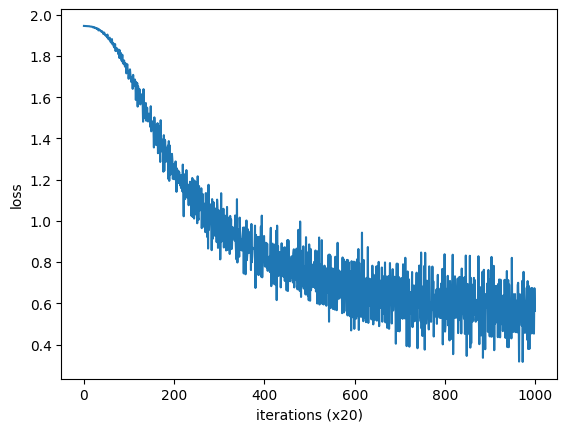

you [-1.152637   1.2406265 -1.1476054  1.1026222  1.0784377]
say [ 1.2119906   0.07885174  1.2025355  -0.71677864 -1.2493712 ]
goodbye [-0.6545541   0.8700723  -0.6849925   0.8572864   0.66757965]
and [ 0.8021923   1.7211291   0.8966693  -1.4857216  -0.79610026]
i [-0.6484298   0.87395054 -0.6534116   0.85718924  0.6680209 ]
hello [-1.1610407  1.228169  -1.1594363  1.1231062  1.0924869]
. [ 1.2432971 -1.4944408  1.2402366  1.4756571 -1.2471172]


In [7]:
import sys
sys.path.append('..')  # 为了引入父目录的文件而进行的设定
from common.trainer import Trainer
from common.optimizer import Adam
from simple_cbow import SimpleCBOW
from common.util import preprocess, create_contexts_target, convert_one_hot


window_size = 1 # 上下文窗口大小
hidden_size = 5 # 隐藏层大小
batch_size = 3 # 批大小
max_epoch = 1000 # 最大迭代次数

text = 'You say goodbye and I say hello.' 
corpus, word_to_id, id_to_word = preprocess(text) # 预处理文本数据

vocab_size = len(word_to_id) # 词汇表大小
contexts, target = create_contexts_target(corpus, window_size) # 生成上下文和目标词
target = convert_one_hot(target, vocab_size) # 转化为one-hot表示
contexts = convert_one_hot(contexts, vocab_size) # 转化为one-hot表示

model = SimpleCBOW(vocab_size, hidden_size) # 生成CBOW模型
optimizer = Adam() # 生成Adam优化器
trainer = Trainer(model, optimizer) # 生成Trainer对象

trainer.fit(contexts, target, max_epoch, batch_size) # 训练模型
trainer.plot() # 绘制学习曲线

word_vecs = model.word_vecs # 获取词向量，本质是输入层的权重W_in
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id]) # 输出单词及其词向量

这里，使用 `word_vecs` 这个变量保存权重。`word_vecs` 的各行保存了对应的单词 ID 的分布式表示。实际运行一下，可以得到上述结果。

我们终于将单词表示为了密集向量！这就是单词的分布式表示。我们有理由相信，这样的分布式表示能够很好地捕获单词含义。

不过，遗憾的是，这里使用的小型语料库并没有给出很好的结果。当然，主要原因是语料库太小了。如果换成更大、更实用的语料库，相信会获得更好的结果。但是，这样在处理速度方面又会出现新的问题，这是因为当前这个 CBOW 模型的实现在处理效率方面存在几个问题。下一章我们将改进这个简单的 CBOW 模型，实现一个 “真正的” CBOW 模型。

## Word2vec的补充说明 
至此，我们详细探讨了word2vec的CBOW模型。接下来，我们将对word2vec补充说明几个非常重要的话题。首先，我们从概率的角度，再来看一下CBOW模型。

## CBOW模型和概率 
首先简单说明一下概率的表示方法。本书中将概率记为 $P(\cdot)$，比如事件 $A$ 发生的概率记为 $P(A)$。**联合概率**记为 $P(A,B)$，表示事件 $A$ 和事件 $B$ 同时发生的概率。

**后验概率**记为 $P(A|B)$，字面意思是“事件发生后的概率”。从另一个角度来看，也可以解释为“在给定事件 $B$（的信息）时事件 $A$ 发生的概率”。

下面，我们用概率的表示方法来描述 CBOW 模型。CBOW 模型进行的处理是，当给定某个上下文时，输出目标词的概率。这里，我们使用包含单词 $w_1, w_2, \cdots, w_T$ 的语料库。如图所示，对第 $t$ 个单词，考虑窗口大小为 1 的上下文。

<img src="./fig/CBOW_word2vec.png" alt="CBOW_word2vec" style="display: block; margin: 0 auto;">

下面，我们用数学式来表示当给定上下文 $w_{t - 1}$ 和 $w_{t + 1}$ 时目标词为 $w_t$ 的概率。使用后验概率，有式 (3.1)：

$$P(w_t | w_{t - 1}, w_{t + 1}) \tag{3.1}$$

式 (3.1) 表示“在 $w_{t - 1}$ 和 $w_{t + 1}$ 发生后，$w_t$ 发生的概率”，也可以解释为“当给定 $w_{t - 1}$ 和 $w_{t + 1}$ 时，$w_t$ 发生的概率”。也就是说，CBOW 模型可以建模为式 (3.1)。

这里，使用式 (3.1) 可以简洁地表示 CBOW 模型的损失函数。我们把第 1 章介绍的交叉熵误差函数（式 (1.7)）套用在这里。式 (1.7) 是 $L = -\sum_k t_k \log y_k$，其中，$y_k$ 表示第 $k$ 个事件发生的概率。$t_k$ 是监督标签，它是 one-hot 向量的元素。这里需要注意的是，“$w_t$ 发生”这一事件是正确解，它对应的 one-hot 向量的元素是 1，其他元素都是 0（也就是说，当 $w_t$ 之外的事件发生时，对应的 one-hot 向量的元素均为 0）。考虑到这一点，可以推导出下式：

$$L = -\log P(w_t | w_{t - 1}, w_{t + 1}) \tag{3.2}$$

CBOW 模型的损失函数只是对式 (3.1) 的概率取 $\log$，并加上负号。顺便提一下，这也称为**负对数似然**（negative log likelihood）。式 (3.2) 是一笔样本数据的损失函数。如果将其扩展到整个语料库，则损失函数可以写为：

$$L = -\frac{1}{T} \sum_{t = 1}^{T} \log P(w_t | w_{t - 1}, w_{t + 1}) \tag{3.3}$$

CBOW 模型学习的任务就是让式 (3.3) 表示的损失函数尽可能地小。那时的权重参数就是我们想要的单词的分布式表示。这里，我们只考虑了窗口大小为 1 的情况，不过其他的窗口大小（或者窗口大小为 $m$ 的一般情况）也很容易用数学式表示。

## skip-gram模型
如前所述，word2vec 有两个模型：一个是我们已经讨论过的 CBOW 模型；另一个是被称为 skip-gram 的模型。skip-gram 是反转了 CBOW 模型处理的上下文和目标词的模型。举例来说，两者要解决的问题如图所示。

<img src="./fig/CBOW_skip_gram.png" alt="CBOW_skip_gram" style="display: block; margin: 0 auto;">

如图所示，CBOW模型从上下文的多个单词预测中间的单词（目标词），而skip-gram模型则从中间的单词（目标词）预测周围的多个单词（上下文）。此时，skip-gram模型的网络结构如下图所示。

<img src="./fig/skip_gram_example.png" alt="skip_gram_example" style="display: block; margin: 0 auto;">

由图可知，skip - gram 模型的输入层只有一个，输出层的数量则与上下文的单词个数相等。因此，首先要分别求出各个输出层的损失（通过 Softmax with Loss 层等），然后将它们加起来作为最后的损失。

现在，我们使用概率的表示方法来表示 skip - gram 模型。我们来考虑根据中间单词（目标词）$w_t$ 预测上下文 $w_{t - 1}$ 和 $w_{t + 1}$ 的情况。此时，skip - gram 可以建模为式 (3.4)：

$$P(w_{t - 1}, w_{t + 1} | w_t) \tag{3.4}$$

式 (3.4) 表示“当给定 $w_t$ 时，$w_{t - 1}$ 和 $w_{t + 1}$ 同时发生的概率”。这里，在 skip - gram 模型中，假定上下文的单词之间没有相关性（正确地说是假定“条件独立”），将式 (3.4) 如下进行分解：

$$P(w_{t - 1}, w_{t + 1} | w_t) = P(w_{t - 1} | w_t) P(w_{t + 1} | w_t) \tag{3.5}$$

通过将式 (3.5) 代入交叉熵误差函数，可以推导出 skip - gram 模型的损失函数：

$$
\begin{align}
L &= -\log P(w_{t - 1}, w_{t + 1} | w_t) \\
&= -\log P(w_{t - 1} | w_t) P(w_{t + 1} | w_t) \tag{3.6} \\
&= -(\log P(w_{t - 1} | w_t) + \log P(w_{t + 1} | w_t))
\end{align}
$$

这里利用了对数的性质 $\log xy = \log x + \log y$。如式 (3.6) 所示，skip - gram 模型的损失函数先分别求出各个上下文对应的损失，然后将它们加在一起。式 (3.6) 是一笔样本数据的损失函数。如果扩展到整个语料库，则 skip - gram 模型的损失函数可以表示为式 (3.7)：

$$L = -\frac{1}{T} \sum_{t = 1}^{T} (\log P(w_{t - 1} | w_t) + \log P(w_{t + 1} | w_t)) \tag{3.7}$$

比较式 (3.7) 和 CBOW 模型的式 (3.3)，差异是非常明显的。因为 skip - gram 模型的预测次数和上下文单词数量一样多，所以它的损失函数需要求各个上下文单词对应的损失的总和。而 CBOW 模型只需要求目标词的损失。以上就是对 skip - gram 模型的介绍。

那么，我们应该使用 CBOW 模型和 skip - gram 模型中的哪一个呢？答案应该是 skip - gram 模型。这是因为，从单词的分布式表示的准确度来看，在大多数情况下，skip - gram 模型的结果更好。特别是随着语料库规模的增大，在低频词和类推问题的性能方面，skip - gram 模型往往会有更好的表现（单词的分布式表示的评价方法会在之后的章节说明）。此外，就学习速度而言，CBOW 模型比 skip - gram 模型要快。这是因为 skip - gram 模型需要根据上下文数量计算相应个数的损失，计算成本变大。

skip-gram模型根据一个单词预测其周围的单词，这是一个非常难的问题。假如我们来解决上图中的问题，此时，对于CBOW模型的问题，我们很容易回答“say”。但是，对于skip-gram模型的问题，则存在许多候选。因此，可以说skip-gram模型要解决的是更难的问题。经过这个更难的问题的锻炼，skip-gram模型能提供更好的单词的分布式表示。

理解了 CBOW 模型的实现，在实现 skip - gram 模型时应该就不存在什么难点了。因此，这里就不再介绍 skip - gram 模型的实现。

In [8]:
import sys
sys.path.append('..') # 为了导入父目录的文件而进行的设定
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss


class SimpleSkipGram:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 初始化权重
        W_in = 0.01 * np.random.randn(V, H).astype('f') # 输入层权重
        W_out = 0.01 * np.random.randn(H, V).astype('f') # 输出层权重

        # 生成层
        self.in_layer = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer1 = SoftmaxWithLoss()
        self.loss_layer2 = SoftmaxWithLoss()

        # 将所有的权重和梯度整理到列表中
        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [], [] # 初始化参数和梯度的列表
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 将单词的分布式表示设置为成员变量
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = self.in_layer.forward(target)
        s = self.out_layer.forward(h)
        l1 = self.loss_layer1.forward(s, contexts[:, 0]) # 第一个上下文
        l2 = self.loss_layer2.forward(s, contexts[:, 1]) # 第二个上下文
        loss = l1 + l2 # 总损失
        return loss

    def backward(self, dout=1):
        dl1 = self.loss_layer1.backward(dout)
        dl2 = self.loss_layer2.backward(dout)
        ds = dl1 + dl2
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        return None

## 基于计数与基于推理
到目前为止，我们已经了解了基于计数的方法和基于推理的方法（特别是 word2vec）。两种方法在学习机制上存在显著差异：基于计数的方法通过对整个语料库的统计数据进行一次学习来获得单词的分布式表示，而基于推理的方法则反复观察语料库的一部分数据进行学习（mini - batch 学习）。这里，我们就其他方面来对比一下这两种方法。

首先，我们考虑需要向词汇表添加新词并更新单词的分布式表示的场景。此时，基于计数的方法需要从头开始计算。即便是想稍微修改一下单词的分布式表示，也需要重新完成生成共现矩阵、进行 SVD 等一系列操作。相反，基于推理的方法（word2vec）允许参数的增量学习。具体来说，可以将之前学习到的权重作为下一次学习的初始值，在不损失之前学习到的经验的情况下，高效地更新单词的分布式表示。在这方面，基于推理的方法（word2vec）具有优势。

其次，两种方法得到的单词的分布式表示的性质和准确度有什么差异呢？就分布式表示的性质而言，基于计数的方法主要是编码单词的相似性，而 word2vec（特别是 skip - gram 模型）除了单词的相似性以外，还能理解更复杂的单词之间的模式。关于这一点，word2vec 因能解开 “king - man + woman = queen” 这样的类推问题而知名（关于类推问题，我们将在之后的章节说明）。

这里有一个常见的误解，那就是基于推理的方法在准确度方面优于基于计数的方法。实际上，有研究表明，就单词相似性的定量评价而言，基于推理的方法和基于计数的方法难分上下。

2014年发表的题为 “Don't count, predict!”（不要计数，要预测！）的论文系统地比较了基于计数的方法和基于推理的方法，并给出了基于推理的方法在准确度上始终更好的结论。但是，之后又有其他的论文提出，就单词的相似性而言，结论高度依赖于超参数，基于计数的方法和基于推理的方法难分胜负。

另外一个重要的事实是，基于推理的方法和基于计数的方法存在关联性。具体地说，使用了 skip - gram 和下一章介绍的 Negative Sampling 的模型被证明与对整个语料库的共现矩阵（实际上会对矩阵进行一定的修改）进行特殊矩阵分解的方法具有相同的作用。换句话说，这两个方法论（在某些条件下）是 “相通” 的。

此外，在 word2vec 之后，有研究人员提出了 GloVe 方法。GloVe 方法融合了基于推理的方法和基于计数的方法。该方法的思想是，将整个语料库的统计数据的信息纳入损失函数，进行 mini - batch 学习。据此，这两个方法论成功地被融合在了一起。

## 小结
- 基于推理的方法以预测为目标，同时获得了作为副产物的单词的分布式表示
- word2vec 是基于推理的方法，由简单的 2 层神经网络构成
- word2vec 有 skip-gram 模型和 CBOW 模型
- CBOW 模型从多个单词（上下文）预测 1 个单词（目标词）
- skip-gram 模型反过来从 1 个单词（目标词）预测多个单词（上下文）
- 由于 word2vec 可以进行权重的增量学习，所以能够高效地更新或添加单词的分布式表示